In [5]:
# Increase my page width
from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))

# Imports
import urllib
import os,sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from pylab import rcParams
from sklearn import feature_extraction
from sklearn import preprocessing
from random import seed, shuffle

<h1>1. Dataset exploration</h1>
In this part we will explore the ProPublica COMPAS dataset by determining the features available for exploration, labels. we also want to analyse performance metrics relating to various race available in the dataset and gender. 
The main goal of this section is to determine and understand the features needed to build a classifier.

<h3>1. 1 ProPublica COMPAS dataset</h3>
we begin by either downloading or loading the dataset, and explring its content.

In [6]:
#function to plot some graphs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42

#downloading or checking for data
SEED = 1234
seed(SEED)
np.random.seed(SEED)

def check_data_file(fname):
    files = os.listdir(".") # get the current directory listing
    print("Looking for file '%s' in the current directory...",fname)

    if fname not in files:
        print("'%s' not found! Downloading from GitHub...",fname)
        addr = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
        response = urllib.request.urlopen(addr)
        data = response.read()
        fileOut = open(fname, "wb")
        fileOut.write(data)
        fileOut.close()
        print("'%s' download and saved locally..",fname)
    else:
        print("File found in current directory..")
    
COMPAS_INPUT_FILE = "compas-scores-two-years.csv"
check_data_file(COMPAS_INPUT_FILE)

pd.options.display.max_columns = None
df=pd.read_csv('compas-scores-two-years.csv')
df

Looking for file '%s' in the current directory... compas-scores-two-years.csv
File found in current directory..


,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.0,F,Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-08-14,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,F,Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,0,8,1,0,1,NaN,NaN,NaN,13000570CF10A,2013-01-12,NaN,1.0,F,Possession of Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,8,High,2013-01-13,Risk of Violence,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,0,1,0,0,2,NaN,NaN,NaN,12014130CF10A,NaN,2013-01-09,76.0,F,arrest case no charge,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-03-26,Risk of Violence,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,0,7,0,0,0,-1.0,2013-11-22 05:18:27,2013-11-24 02:59:20,13016249CF10A,2013-11-22,NaN,1.0,F,Deliver Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,7,Medium,2013-11-23,Risk of Violence,5,Medium,2013-11-23,2013-11-22,2013-11-24,0,1,860,0,0
7210,10997,malcolm simmons,malcolm,simmons,2014-02-01,Male,1993-03-25,23,Less than 25,African-American,0,3,0,0,0,-1.0,2014-01-31 07:13:54,2014-02-02 04:03:52,14001422CF10A,2014-01-31,NaN,1.0,F,Leaving the Scene of Accident,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,3,Low,2014-02-01,Risk of Violence,5,Medium,2014-02-01,2014-01-31,2014-02-02,0,1,790,0,0
7211,10999,winston gregory,winston,gregory,2014-01-14,Male,1958-10-01,57,Greater than 45,Other,0,1,0,0,0,-1.0,2014-01-13 05:48:01,2014-01-14 07:49:46,14000581CF10A,2014-01-13,NaN,1.0,F,Aggravated Battery / Pregnant,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2014-01-14,Risk of Violence,1,Low,2014-01-14,2014-01-13,2014-01-14,0,0,808,0,0
7212,11000,farrah jean,farrah,jean,2014-03-09,Female,1982-11-17,33,25 - 45,African-American,0,2,0,0,3,-1.0,2014-03-08 08:06:02,2014-03-09 12:18:04,140033

From the display of the datset above, we have 53 columns and 7214 rows.
Not all columns will be needed to analyse the data so we have to filter un-needed columns.to deide, we can display colummns having empty values to determine if they will have much much impact on the exploration or not.

In [7]:
#sum of null values per column
df.isnull().sum()

id                            0
name                          0
first                         0
last                          0
compas_screening_date         0
sex                           0
dob                           0
age                           0
age_cat                       0
race                          0
juv_fel_count                 0
decile_score                  0
juv_misd_count                0
juv_other_count               0
priors_count                  0
days_b_screening_arrest     307
c_jail_in                   307
c_jail_out                  307
c_case_number                22
c_offense_date             1159
c_arrest_date              6077
c_days_from_compas           22
c_charge_degree               0
c_charge_desc                29
is_recid                      0
r_case_number              3743
r_charge_degree            3743
r_days_from_arrest         4898
r_offense_date             3743
r_charge_desc              3801
r_jail_in                  4898
r_jail_o

We can see from the data above, some columns such as r_case, r_charge_degree have a huge amount of empty values. We can't use these part of the data to build our classifier or do any analysis as it will be biased. Columns such as id and name will also not be needed to do our analysis because we will not need the name of the person to see how our classifier will perform in the next part.

<h3>1.2 Filtered Dataset</h3>
 We will first remove all columns which contain null (NaN) values, followed by listing each column with how many unique values they have.

In [8]:
df = df[df.columns[~df.isnull().any()]]
df.nunique()

id                       7214
name                     7158
first                    2800
last                     3950
compas_screening_date     690
sex                         2
dob                      5452
age                        65
age_cat                     3
race                        6
juv_fel_count              11
decile_score               10
juv_misd_count             10
juv_other_count            10
priors_count               37
c_charge_degree             2
is_recid                    2
is_violent_recid            2
type_of_assessment          1
decile_score.1             10
score_text                  3
screening_date            690
v_type_of_assessment        1
v_decile_score             10
v_score_text                3
v_screening_date          690
priors_count.1             37
start                     237
end                      1115
event                       2
two_year_recid              2
dtype: int64

By observing our result, some columns have large number of unique values. 
These may indicate that they are not relevant, which means we can drop them. We can also see there are some columns which only have 1 unique value, we will not use these data because we cant use to compare with our variables.

now, we select the needed columns for exploration of the dataset. this totals up to 17 columns

In [9]:
df = df[['sex','age_cat', 'race', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree', 'is_recid', 
         'is_violent_recid', 'decile_score', 'decile_score.1', 'score_text', 'v_decile_score', 'v_score_text', 'priors_count.1', 'event', 'two_year_recid']]
df.head()

,sex,age_cat,race,juv_fel_count,juv_misd_count,priors_count,c_charge_degree,is_recid,is_violent_recid,decile_score,decile_score.1,score_text,v_decile_score,v_score_text,priors_count.1,event,two_year_recid
0,Male,Greater than 45,Other,0,0,0,F,0,0,1,1,Low,1,Low,0,0,0
1,Male,25 - 45,African-American,0,0,0,F,1,1,3,3,Low,1,Low,0,1,1
2,Male,Less than 25,African-American,0,0,4,F,1,0,4,4,Low,3,Low,4,0,1
3,Male,Less than 25,African-American,0,1,1,F,0,0,8,8,High,6,Medium,1,0,0
4,Male,25 - 45,Other,0,0,2,F,0,0,1,1,Low,1,Low,2,0,0


<h3>1.3 Performance Metrics</h3>
We will compute basic performance metrics of the COMPAS classifier in this section. As mentioned in the document, the main issue of this classifier is biased towards certain racial group.
We will first present the number of criminals based on their race.

African-American    3696
Caucasian           2454
Hispanic             637
Other                377
Asian                 32
Native American       18
Name: race, dtype: int64

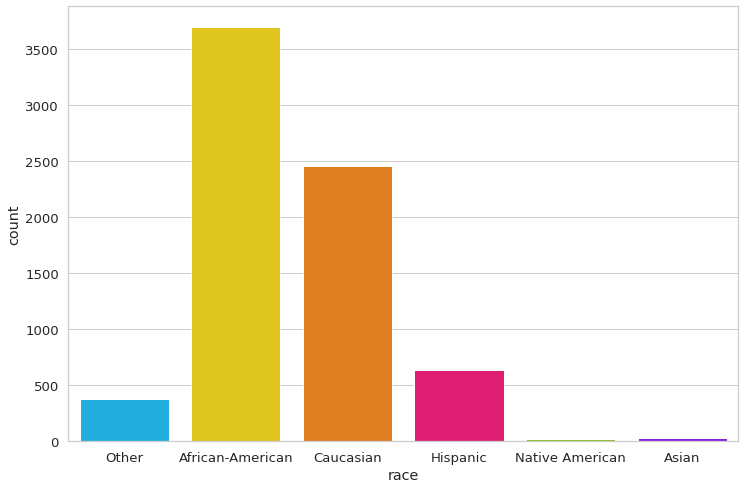

In [10]:
#df2=pd.read_csv('compas-scores-two-years.csv')
sns.countplot(df.race)
df.race.value_counts()

As shown above this variety of races may has an effect on the result of classifier since race 'African-American' number almost as the same other races combined. To analyze further, we will present histograms of 'decile_score' for each race.

We now want to know how many people are classified under the labels (risk label and risk rating)

In [11]:
# number of people in each risk labels
df.score_text.value_counts()

Low       3897
Medium    1914
High      1403
Name: score_text, dtype: int64

judges are always presented with 2 labels (one that classifies people into High, Medium and Low risk, and a corresponding decile score)

#### Decile_Scores (Risk scores)
the decile score ranges from 1 to 10 with 1 being the least probability to recidiviate and 10 being the highest.
below is a distribution of the decile scores according to the race categories


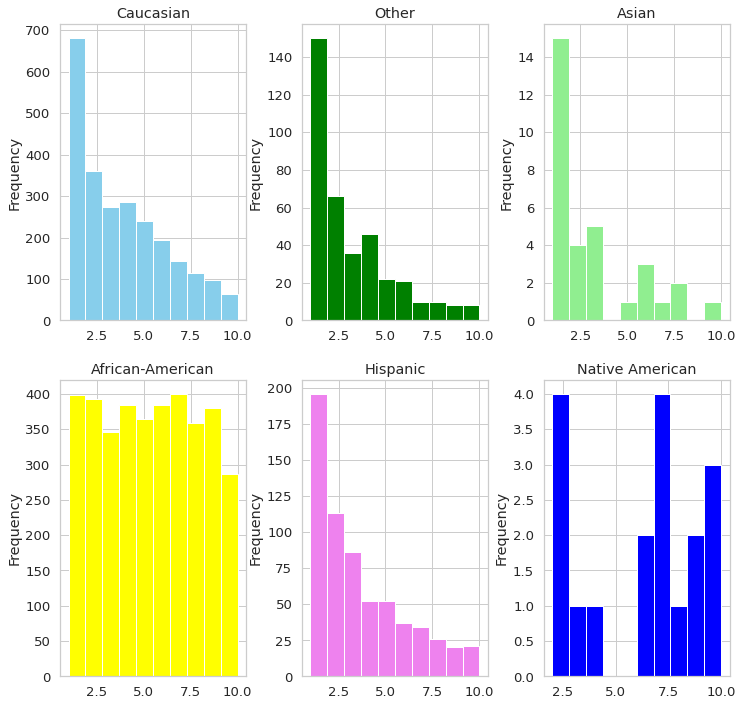

In [12]:

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,12))
plt.subplots_adjust(wspace=0.3, hspace=0.2)

df['decile_score'].loc[df['race'] == 'Caucasian'].plot(ax=axes[0,0], kind='hist', color = "skyblue", title='Caucasian')
df['decile_score'].loc[df['race'] == 'Other'].plot(ax=axes[0,1],kind='hist', color = "green", title='Other')
df['decile_score'].loc[df['race'] == 'Asian'].plot(ax=axes[0,2],kind='hist', color = "lightgreen", title='Asian')
df['decile_score'].loc[df['race'] == 'African-American'].plot(ax=axes[1,0],kind='hist', color = "yellow", title='African-American')
df['decile_score'].loc[df['race'] == 'Hispanic'].plot(ax=axes[1,1],kind='hist', color = "violet", title='Hispanic')
df['decile_score'].loc[df['race'] == 'Native American'].plot(ax=axes[1,2],kind='hist', color = "blue", title='Native American')

From histograms above we can see that every races has similar pattern, except 'African-American' which the distribution tends to be uniformly distributed accross the decile scores. African-Americans are almost equally likely to receive any score while other races have majority of their population on low values.

#### Compass Classifier
Now we will look into the performance of the COMPAS classifier. According to COMPAS 'two_year_recid' is the ground truth wether the criminals actually recidivated or not. Therefore we can use this data to compute the accuracy of COMPAS classifier by considering value of 'score_text'. To simplify we will consider if the value of 'score_text' is 'High', it means that the classifer tells that the corresponding criminal will redivicate.<br><br>

Practically, we will first need to convert the column 'score_text' into 0 and 1 values. Then we will use tools from skcit learn to compute the accuracy, also other metrics such as Precision and Recall.

In [14]:
nparray = pd.DataFrame(df['score_text']).to_numpy()
nparray1 = pd.DataFrame(df['two_year_recid']).to_numpy()
i = 0
for x in nparray:
    if x == "Low":
        nparray[i] = 0
    else:
        nparray[i] = 1
    i = i + 1

y_pred = nparray.astype('int')
y_true = nparray1.astype('int')
print("Accuracy\t: " + str(accuracy_score(y_true, y_pred)))
print("Precision\t: " + str(precision_score(y_true, y_pred)))
print("Recall\t\t: " + str(recall_score(y_true, y_pred)))

Accuracy	: 0.6537288605489326
Precision	: 0.6135061802833887
Recall		: 0.6259612426945556


We can see that all of the performance metric values are pretty low. The crowd based accuracy is at 65% with no race condition attached.
This indicates that the classifer has a poor performance. To analyze further 
We will compute the metrics for each race to see if the accuracy is evenly distributed.

In [22]:
races = df.race.unique()
for race in races:
    nparray = pd.DataFrame(df['score_text'].loc[df['race'] == race]).to_numpy()
    nparray1 = pd.DataFrame(df['two_year_recid'].loc[df['race'] == race]).to_numpy()
    i = 0
    for x in nparray:
        if x == "Low":
            nparray[i] = 0
        else:
            nparray[i] = 1
        i = i + 1
        
    y_pred = nparray.astype('int')
    y_true = nparray1.astype('int')
    print(race+" Offenders => ")
    print("Accuracy\t: " + str(accuracy_score(y_true, y_pred)))
    print("Precision\t: " + str(precision_score(y_true, y_pred)))
    print("Recall\t\t: " + str(recall_score(y_true, y_pred)) + "\n")
    

Other Offenders => 
Accuracy	: 0.6657824933687002
Precision	: 0.5443037974683544
Recall		: 0.3233082706766917

African-American Offenders => 
Accuracy	: 0.6382575757575758
Precision	: 0.6297148114075437
Recall		: 0.7201472908995266

Caucasian Offenders => 
Accuracy	: 0.6699266503667481
Precision	: 0.5913348946135831
Recall		: 0.5227743271221532

Hispanic Offenders => 
Accuracy	: 0.6609105180533752
Precision	: 0.5421052631578948
Recall		: 0.44396551724137934

Native American Offenders => 
Accuracy	: 0.7777777777777778
Precision	: 0.75
Recall		: 0.9

Asian Offenders => 
Accuracy	: 0.84375
Precision	: 0.75
Recall		: 0.6666666666666666



With respect to fairness, participant accuracy is not significantly different for black defendants (63.8%) compared with other race defendants. We can therefore not conclude that including race has a significant impact on overall accuracy or fairness. The exclusion of race does not necessarily lead to the elimination of racial disparities in human recidivism prediction.

### not sure --- Having low accuracy from the classifier was because the data is not linearly separable, then we would have expected it to perform better. We show below a representation of the results in graphs.
#### Accuracy graph

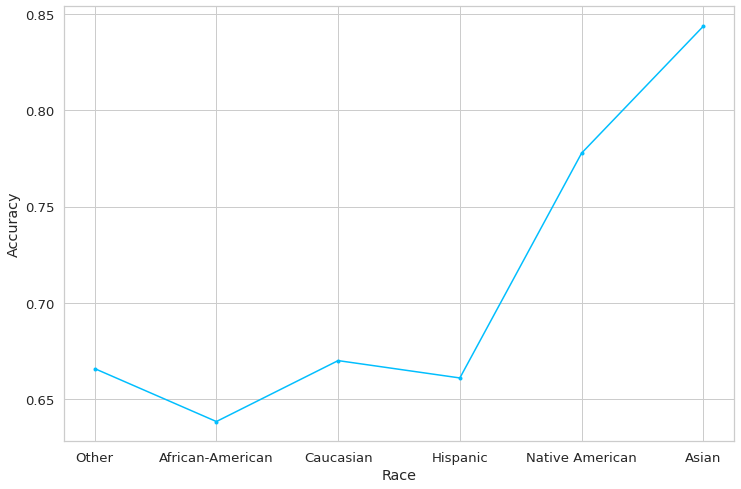

In [63]:
Race = df['race']
Race = Race.unique()

Accuracy = [0.6657824933687002, 0.6382575757575758, 0.6699266503667481, 0.6609105180533752, 0.7777777777777778, 0.84375]
plt.plot(Race, Accuracy, marker='.')
plt.xlabel('Race')
plt.ylabel('Accuracy')
plt.show()

#### Precision Graph

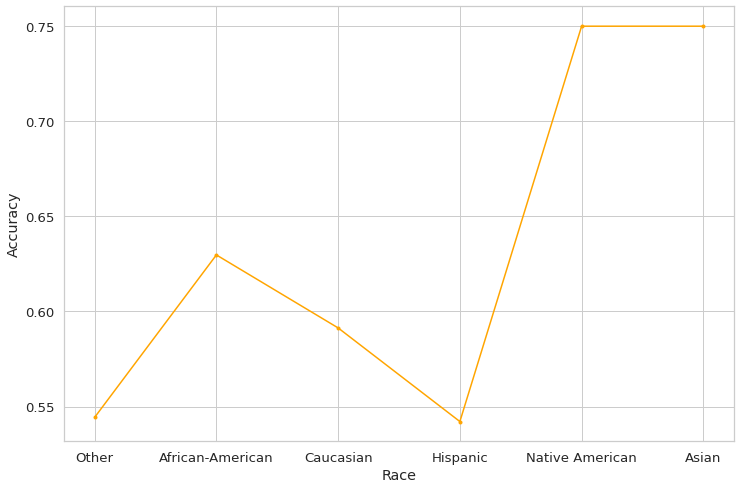

In [57]:
Precison = [0.5443037974683544, 0.6297148114075437, 0.5913348946135831, 0.5421052631578948, 0.75, 0.75]
plt.plot(Race, Precison, marker='.',color="orange")
plt.xlabel('Race')
plt.ylabel('Accuracy')
plt.show()

### Recall Graph

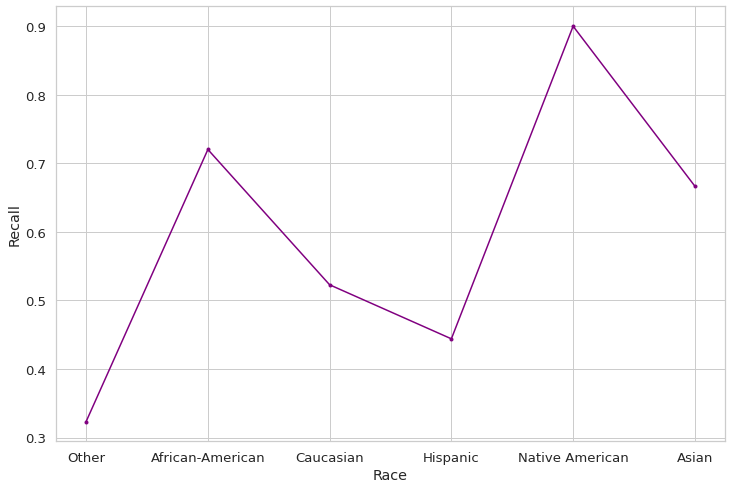

In [58]:
Recall = [0.3233082706766917, 0.7201472908995266, 0.5227743271221532, 0.44396551724137934, 0.9, 0.6666666666666666]
plt.plot(Race, Recall, marker='.', color="purple")
plt.xlabel('Race')
plt.ylabel('Recall')
plt.show()